In [ ]:
#To install the necessary packages, please run this cell:
!pip install -r pip_requirements.txt


In [1]:
# import libraries 
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import seaborn as sns

# Add 'src' to the system path
sys.path.append(str(Path().resolve() / 'src'))
from src.data.process_data import create_tmdb_dataset
from src.utils.load_data import load_raw_data
from src.utils.data_utils import *
from src.utils.plot_utils import *
from src.models.lda_model import *

[nltk_data] Downloading package stopwords to /Users/chsce/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Our analysis centers on the effect DVDs on the movie industry. This question was motivated by an interview with actor Matt Damon, famous for his role in [Good Will Hunting](https://www.imdb.com/title/tt0119217/?ref_=ext_shr_lnk) and [the Martian](https://www.imdb.com/title/tt3659388/?ref_=ext_shr_lnk). 

In the interview with the [New York Times](https://www.nytimes.com/2021/07/27/magazine/matt-damon.html) , he claims that with the fall of DVDs, production companies lost a sizeable portion of their revenue and must rely almost entirely on box office revenues. The consequence of this, he claims, is that movies are now simpler and more international, to ensure broad appeal and better revenues at the box office:

"You know, because the DVD market dried up [...] that severely cut into the margins that studios would rather bet big on these big titles. And with this whole international audience, the more, you know, the simpler the story the more that it can kind of play, the less language matters so that the more broad appeal that it can play around the world, and that’s why you’re seeing the movies change."

With this in mind, we will analyze the effect of DVDs on the movie industry by looking at the following aspects:
- [DVD releases over time](#DVD-releases-over-time)
- [General Overview](#General-Overview)
- [Revenue](#Revenue-overview) 
- [Budget](#Budget-overview)
- [Production company](#Production-companies)
- [Runtime](#Runtime-overview)   
- [Genre](#Genre-overview)
- [Themes](#Themes-extraction)


IMPORTANT: these scripts/functions assume you have the following files in the data/raw directory:
- From the CMU dataset: 
    - movie.metadata.tsv
    - plot_summaries.txt
- From the TMDB dataset: 
    - TMDB_movie_dataset_v11.csv

AND have data/processed folder created

Note: download CMU dataset [here](https://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz)
and TMDB dataset [here (Download button)](https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies)

In [13]:
# from clean data files, creates a dataframe with TMDB movies 
df = create_tmdb_dataset('data/processed/TMDB_clean.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 361971 entries, 0 to 453228
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   title                 361970 non-null  object
 1   release_date          361971 non-null  object
 2   revenue               361971 non-null  int64 
 3   runtime               361971 non-null  int64 
 4   budget                361971 non-null  int64 
 5   original_language     361971 non-null  object
 6   overview              361971 non-null  object
 7   genres                361971 non-null  object
 8   production_companies  361971 non-null  object
 9   production_countries  361971 non-null  object
 10  spoken_languages      361971 non-null  object
 11  keywords              361971 non-null  object
 12  release_year          361971 non-null  int64 
 13  dvd_era               361971 non-null  object
dtypes: int64(4), object(10)
memory usage: 41.4+ MB


There should be 361,971 entries in the dataframe. 

In [15]:
df.head()

,title,release_date,revenue,runtime,budget,original_language,overview,genres,production_companies,production_countries,spoken_languages,keywords,release_year,dvd_era
0,inception,2010-07-15,825532764,148,160000000,en,"cobb, a skilled thief who commits corporate es...","[action, science fiction, adventure]","[legendary pictures, syncopy, warner bros. pic...","[united kingdom, united states of america]","[english, french, japanese, swahili]","[rescue, mission, dream, airplane, paris, fran...",2010,during
1,interstellar,2014-11-05,701729206,169,165000000,en,the adventures of a group of explorers who mak...,"[adventure, drama, science fiction]","[legendary pictures, syncopy, lynda obst produ...","[united kingdom, united states of america]",[english],"[rescue, future, spacecraft, race against time...",2014,post
2,the dark knight,2008-07-16,1004558444,152,185000000,en,batman raises the stakes in his war on crime. ...,"[drama, action, crime, thriller]","[dc comics, legendary pictures, syncopy, isobe...","[united kingdom, united states of america]","[english, mandarin]","[joker, sadism, chaos, secret identity, crime ...",2008,during
3,avatar,2009-12-15,2923706026,162,237000000,en,"in the 22nd century, a paraplegic marine is di...","[action, adventure, fantasy, science fiction]","[dune entertainment, lightstorm entertainment,...","[united states of america, united kingdom]","[english, spanish]","[future, society, culture clash, space travel,...",2009,during
4,the avengers,2012-04-25,1518815515,143,220000000,en,when an unexpected enemy emerges and threatens...,"[science fiction, action, adventure]",[marvel studios],[united states of america],"[english, hindi, russian]","[new york city, superhero, shield, based on co...",2012,during


In [53]:
df.describe()

,revenue,runtime,budget,release_year
count,3.619710e+05,361971.000000,3.619710e+05,361971.000000
mean,1.938350e+06,66.242235,7.506303e+05,2006.753345
std,2.855257e+07,52.716361,7.763083e+06,13.084012
min,0.000000e+00,0.000000,0.000000e+00,1976.000000
25%,0.000000e+00,0.000000,0.000000e+00,1998.000000
50%,0.000000e+00,83.000000,0.000000e+00,2010.000000
75%,0.000000e+00,98.000000,0.000000e+00,2018.000000
max,2.923706e+09,500.000000,8.880000e+08,2023.000000


We see that not all movies have revenue, runtime, or budget information as they are set to zero. However, we keep these movies in our dataset as they might be associated other relevant information. For any analysis pertaining to these features, we ensure instead to exclude any movies for which their value is 0. 

To start our analysis we looked at DVD releases over time to properly define our eras. 


# DVD releases over time

In [16]:
df_dvd_releases = load_raw_data('data/processed/dvd_releases.csv')
df_dvd_releases['dvd_release_date'] = pd.to_datetime(df_dvd_releases['dvd_release_date'])
df_grouped = df_dvd_releases.resample('ME', on='dvd_release_date').size()

Loading data from data/processed/dvd_releases.csv...


In [17]:
# Calculate our eras using our data
peak_date = df_grouped.idxmax()
peak_value = df_grouped.max()
mean_releases = df_grouped.mean()
std_releases = df_grouped.std()
threshold_low = mean_releases - std_releases
threshold_high = mean_releases + std_releases

pre_dvd_end = df_grouped[df_grouped > threshold_high].index[0]  # First time crosses upper threshold
post_dvd_start = df_grouped[df_grouped > threshold_high].index[-1]  # Last time crosses upper threshold
print(f"Pre-DVD Era: Before {pre_dvd_end.strftime('%Y')}")
print(f"DVD Era: {pre_dvd_end.strftime('%Y')} to {post_dvd_start.strftime('%Y')}")
print(f"Post-DVD Era: After {post_dvd_start.strftime('%Y')}")

Pre-DVD Era: Before 1997
DVD Era: 1997 to 2013
Post-DVD Era: After 2013


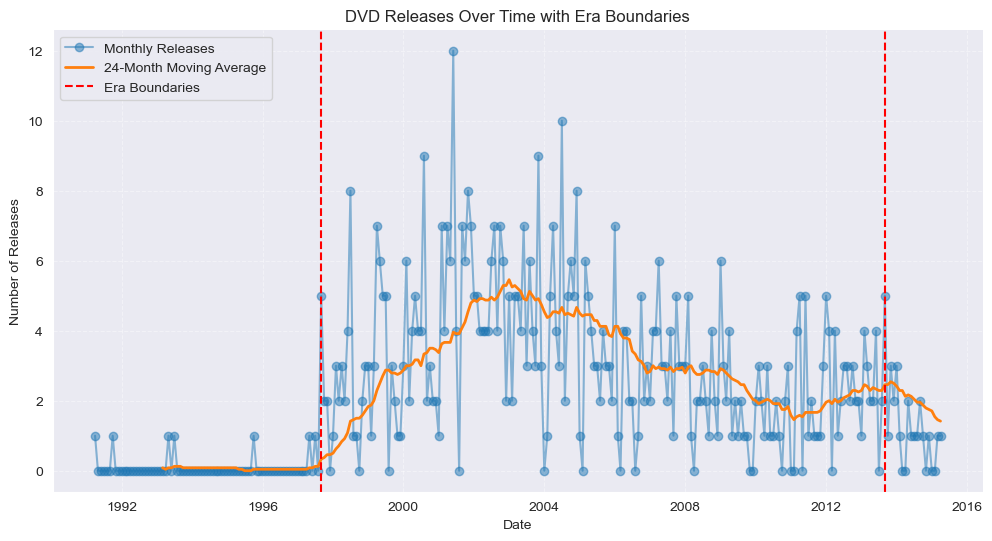

In [18]:
moving_avg = df_grouped.rolling(window=24).mean() 
plt.figure(figsize=(12, 6))

plt.plot(df_grouped.index, df_grouped.values, marker='o', alpha=0.5, label='Monthly Releases')
plt.plot(moving_avg.index, moving_avg.values, linewidth=2, label='24-Month Moving Average')

# Draw the era boundaries
plt.axvline(x=pre_dvd_end, color='r', linestyle='--', label='Era Boundaries')
plt.axvline(x=post_dvd_start, color='r', linestyle='--')

style_plot('DVD Releases Over Time with Era Boundaries', 'Date', 'Number of Releases', True)

# General Overview

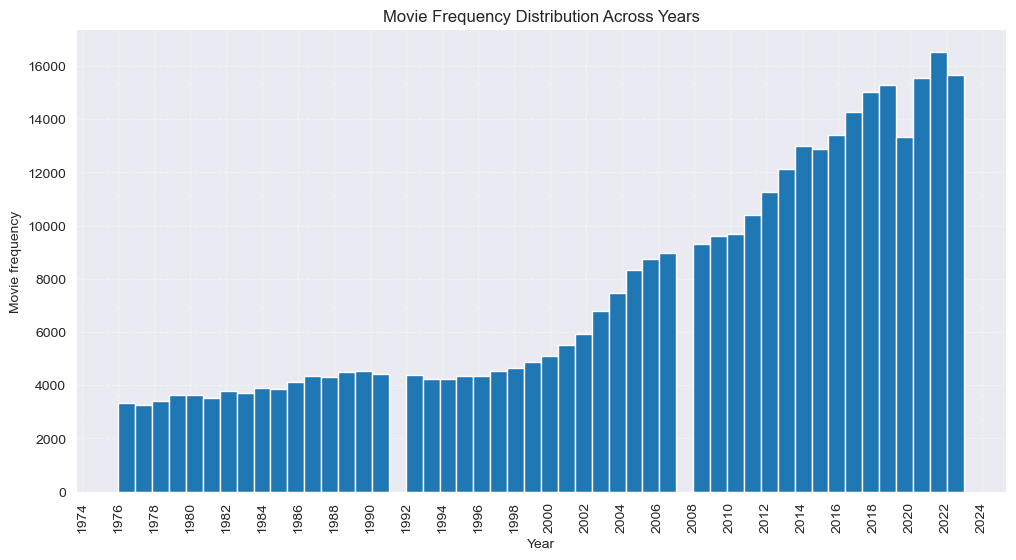

In [19]:
# Get a general distribution of movies
plt.figure(figsize=(12, 6))

plt.hist(df['release_year'], bins=50)
plt.locator_params(axis='x', nbins=50) 
plt.xticks(rotation=90)
style_plot('Movie Frequency Distribution Across Years', 'Year', 'Movie frequency')

# Revenue overview
We first obtain an overview of movie revenues, considering all movies together.

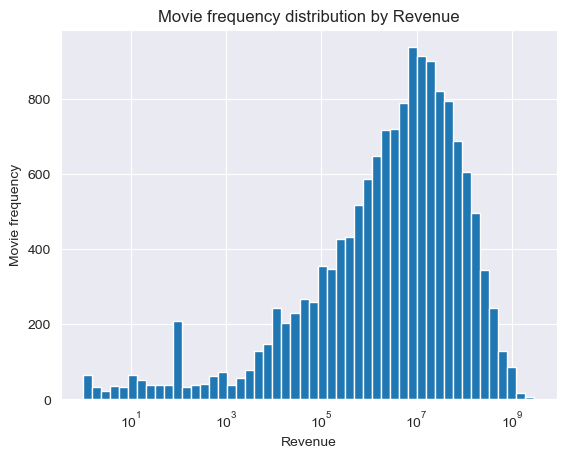

In [21]:
# Frequency distribution per budget, with budget in logscale 
plot_loghist(df[df['revenue'] > 0]['revenue'], 50, xlabel='Revenue', ylabel='Movie frequency')

We then analyse revenue by DVD eras.

In [54]:
# Summary statistics for each DVD era
print('Summary statistics of revenue for each DVD era:')
df[df.revenue > 0].groupby('dvd_era')['revenue'].describe().reindex(['pre', 'during', 'post']).transpose()

Summary statistics of revenue for each DVD era:


dvd_era,pre,during,post
count,3.076000e+03,6.111000e+03,5.851000e+03
mean,3.272585e+07,5.125786e+07,4.917536e+07
std,7.217945e+07,1.278537e+08,1.585504e+08
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.222952e+06,5.169995e+05,1.000000e+05
50%,8.930740e+06,6.638849e+06,2.266853e+06
75%,2.921021e+07,4.196970e+07,2.029698e+07
max,9.201000e+08,2.923706e+09,2.800000e+09


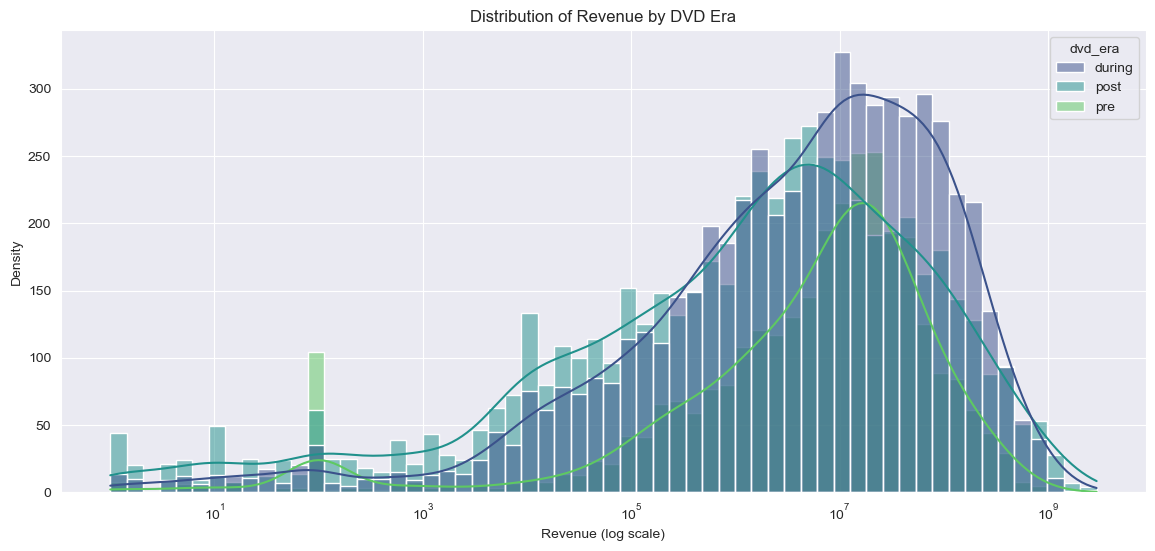

In [22]:
# Revenue per era
plot_revenue_per_era(df)

# Budget overview
We then consider budget distributions.

In [56]:
df_filtered = df[(df['budget'] > 0)]

print('Summary statistics of budget for each DVD era:')
df_filtered.groupby('dvd_era')['budget'].describe().reindex(['pre', 'during', 'post']).transpose()

Summary statistics of budget for each DVD era:


dvd_era,pre,during,post
count,3.042000e+03,9.453000e+03,1.157500e+04
mean,1.101536e+07,1.420990e+07,8.973783e+06
std,1.489062e+07,2.886358e+07,2.977284e+07
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,6.000000e+05,2.000000e+05,3.488000e+03
50%,5.500000e+06,2.400000e+06,1.500000e+05
75%,1.500000e+07,1.400000e+07,3.588572e+06
max,1.750000e+08,3.790000e+08,8.880000e+08


We can see that most budget statistics (quantiles, median and mean) are lower in the post-DVD era, but the maximum budget is higher. 

We examine the budget trends in more details using plots. 

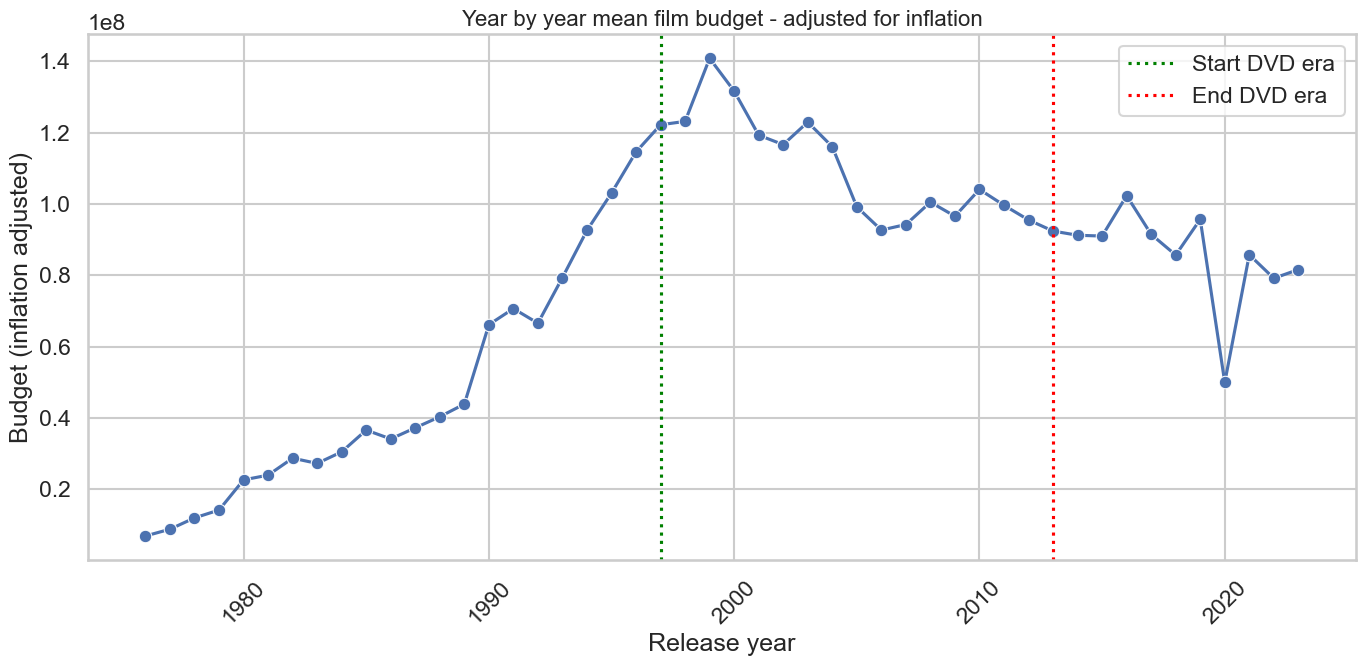

In [24]:
# Plot mean budget across time, accounting for inflation
plot_mean_budget_inflation(df)

We can use histograms to compare film budgets before, during and after the DVD era. We use a log-scale to represent movies with both small and high budgets on the same graph. This leads to the results of pre vs. post DVD era to be unreadable. 


We can nevertheless interpret the results for adjacent eras :
- Pre vs. during: before DVDs, only high budgets films were produced, with a mono-modal distribution, around 10^7 dollars budget. During the DVD era, the distribution widened, with smaller budget films being produced.
- During vs. post: after the DVD era, we see the distribution becoming more bimodal with another density maximum around 10^4 dollars.

Interpreting this is tricky : maybe more movies can become available in streaming services, pushing for smaller-budget productions.

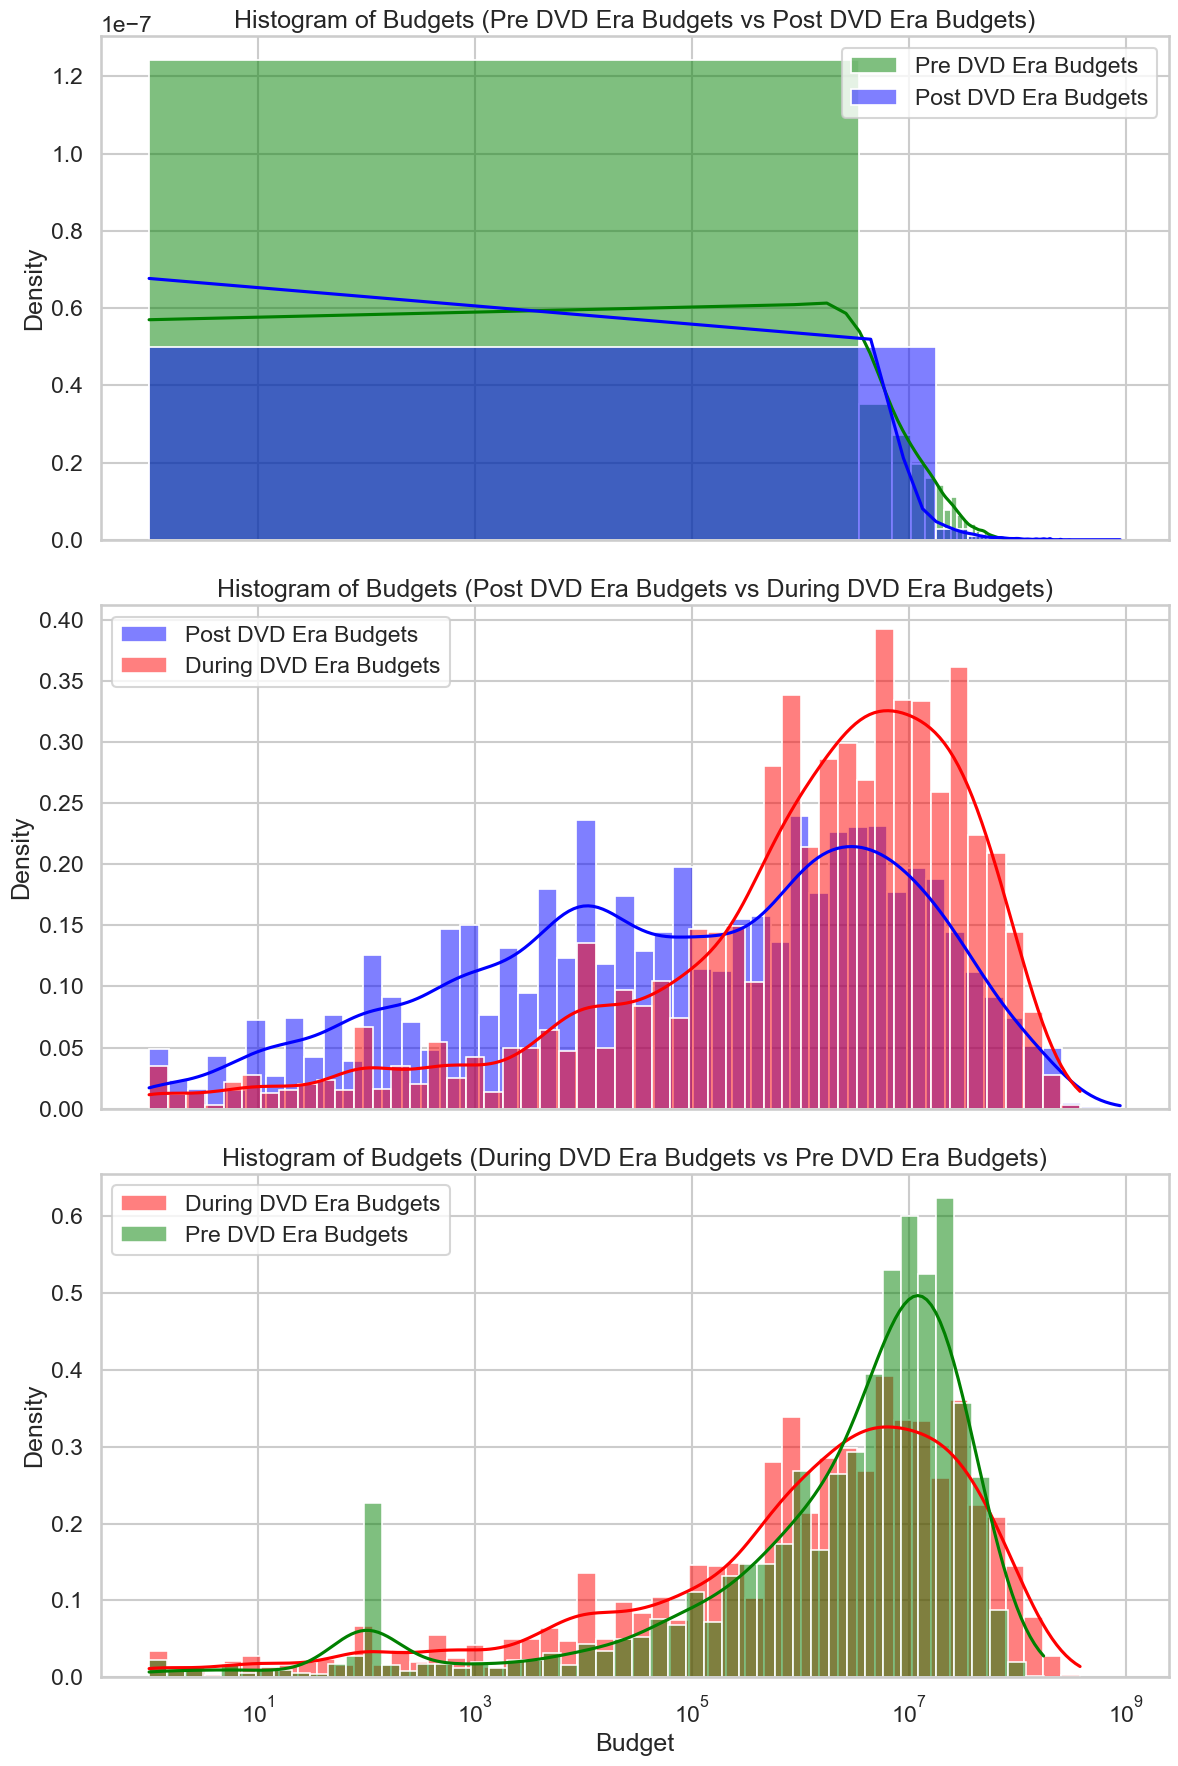

In [25]:

# Define eras, colors, and labels for the plots
eras = [("pre", "post"), ("post", "during"), ("during", "pre")]
colors = [('green', 'blue'), ('blue', 'red'), ('red', 'green')]
labels = [('Pre DVD Era Budgets', 'Post DVD Era Budgets'), 
          ('Post DVD Era Budgets', 'During DVD Era Budgets'), 
          ('During DVD Era Budgets', 'Pre DVD Era Budgets')]

# Plot histograms
plot_budget_histograms(df_filtered, eras, colors, labels, 'Histogram of Budgets')

## Production types

We categorize the movies in different types according to their budgets (compared to the mean) :
- Independent movies: less than 1/10th of the mean budget.
- Small productions: Between 1/10th and 1 of the mean budget.
- Big productions: Between 1 and 5 times the mean budget.
- Super productions More than 5 times the mean budget.

We then plot the proportion of those movies (over the total) using a 3 years rolling average.

The most interesting finding is that the DVD era seems to correspond to a loss of interest for really expensive movies. This can be explained by the fact that :
- Before DVDs, going to the cinema was exceptional, but also the only way to consume movies. So only big franchises with high production budgets could really make a lot of profit.
- After DVDs, the streaming platforms want to differentiate from each other by giving access to exceptional movies, that are really costly.

/Users/chsce/Documents/ada-2024-project-databand/src/utils/data_utils.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'budget_category'] = df.apply(categorize_budget, args=(budget_stats,), axis=1)


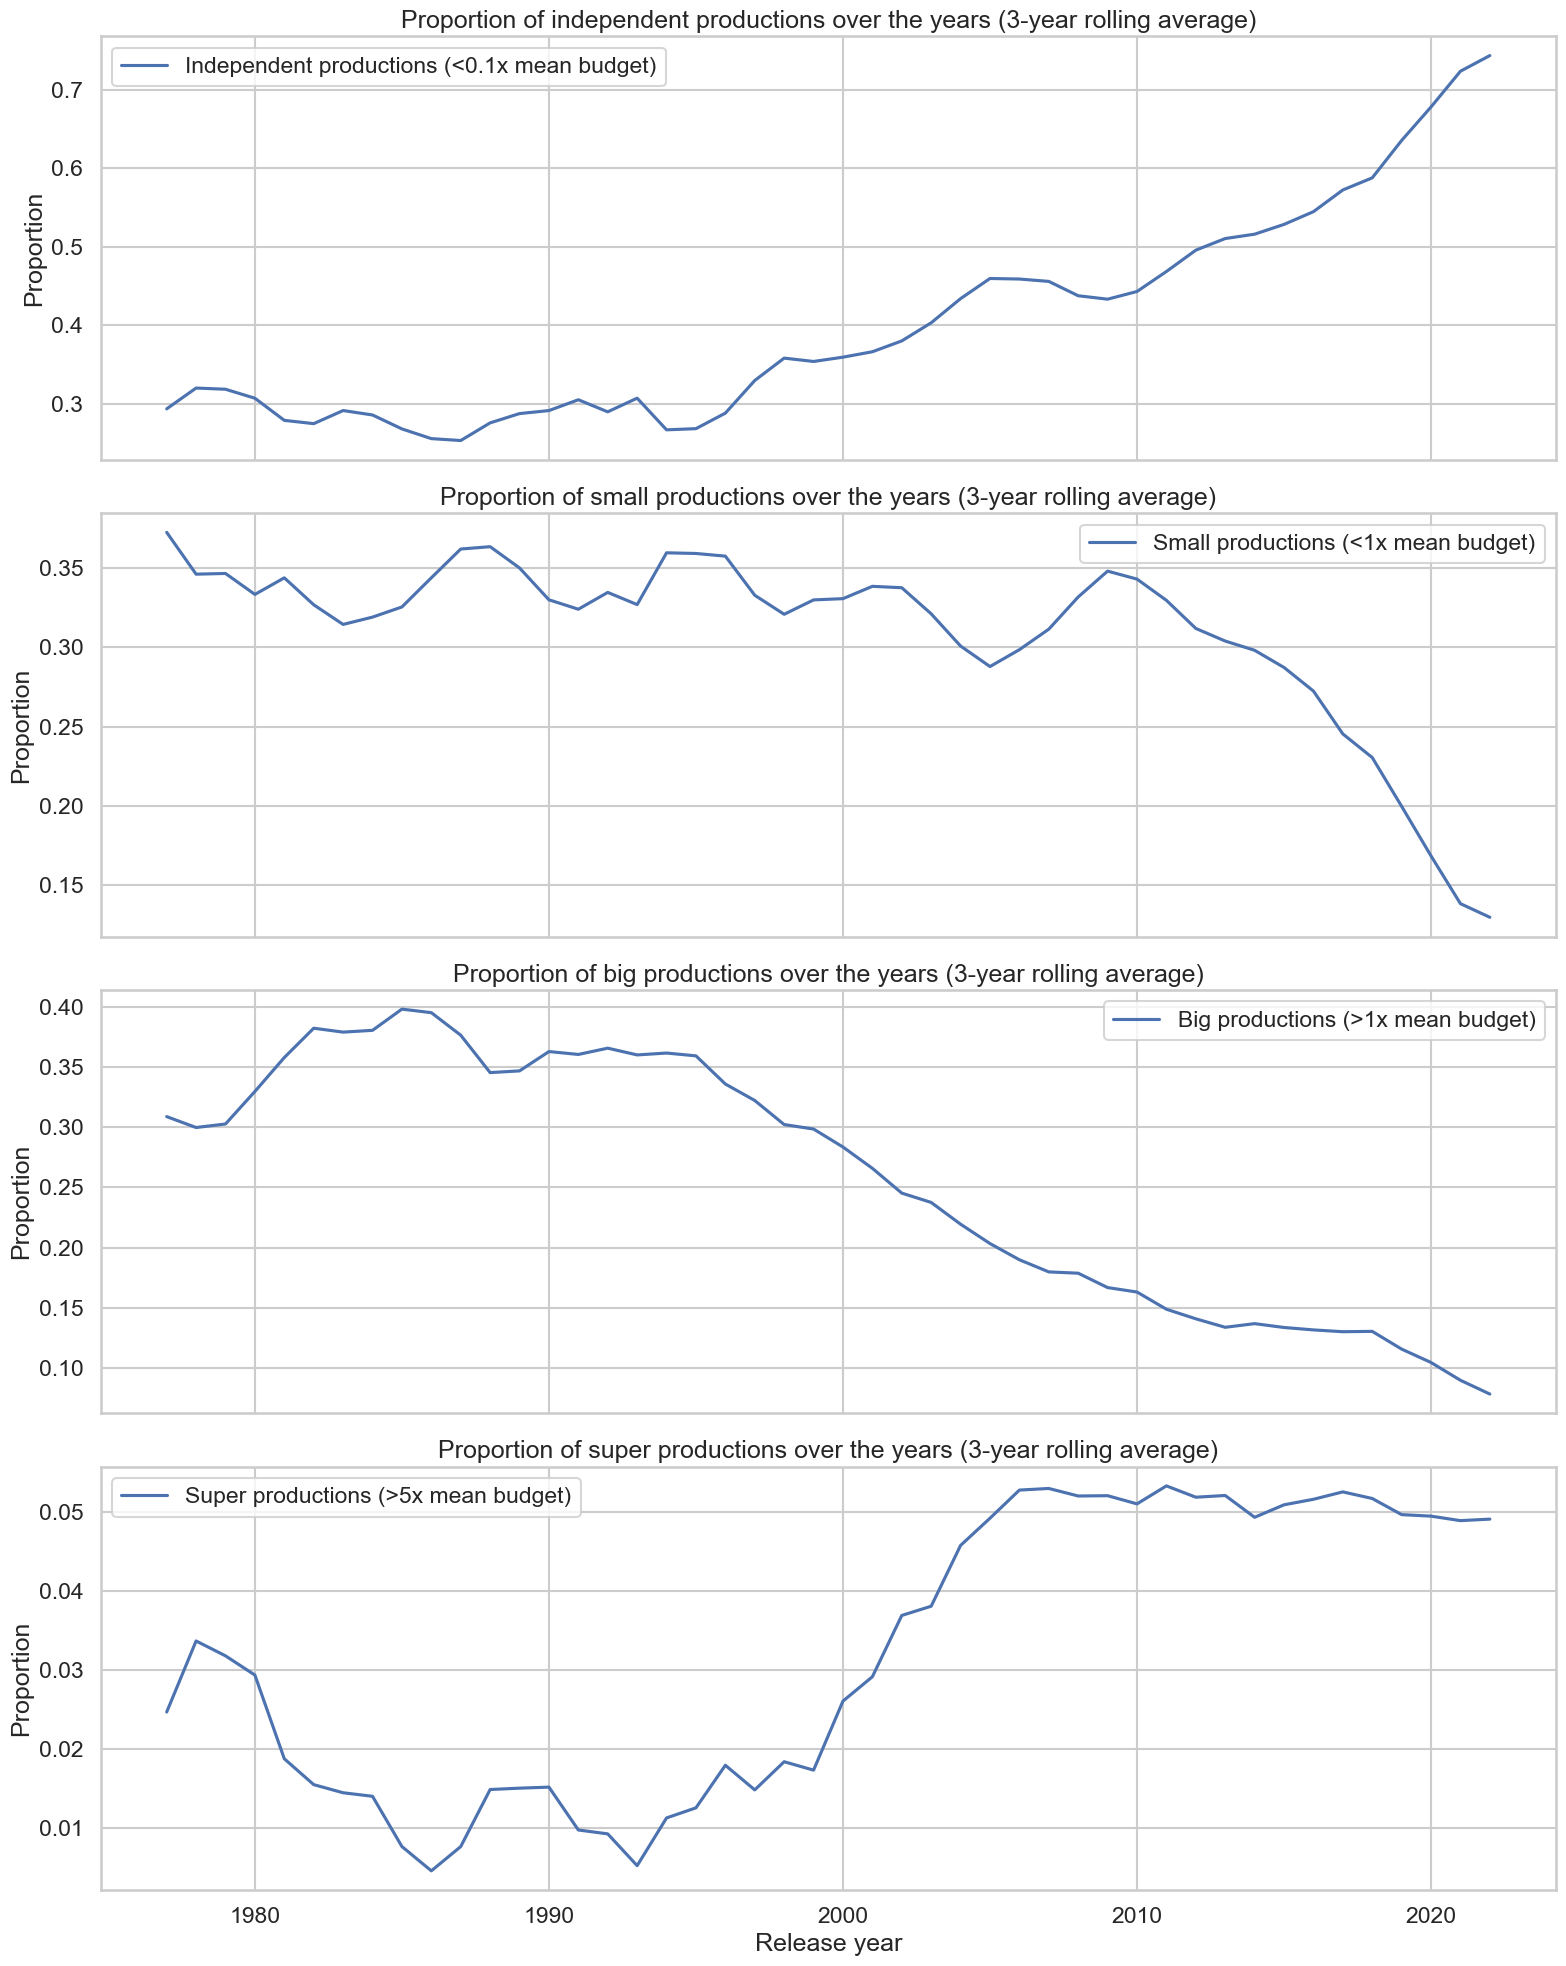

In [26]:
prop_rolling_avg = budget_rolling_averages(df_filtered, window=3)
plot_rolling_averages(prop_rolling_avg)

# Production Companies

We then take a look at production companies

In [85]:
# Get number of production companies for each movie 
num_production_companies = df['production_companies'].str.len()

# Get most common number of production companies with their counts 
company_counts = num_production_companies.value_counts().sort_index()
company_counts.head()

production_companies
0    186851
1    105559
2     37000
3     17091
4      7066
Name: count, dtype: int64

Notice, there are 230,141 with no production companies, we will make sure to exclude these for this part of the analysis. 


In [86]:
print(f"Movies with single production company: {company_counts.get(1, 0):,} ({company_counts.get(1, 0)/company_counts.sum()*100:.1f}%)")
print(f"Movies with multiple production companies: {company_counts[company_counts.index > 1].sum():,} ({company_counts[company_counts.index > 1].sum()/company_counts.sum()*100:.1f}%)")

Movies with single production company: 105,559 (29.2%)
Movies with multiple production companies: 69,561 (19.2%)



Considering movies that have >=1 production company, we plot the frequency distribution. 

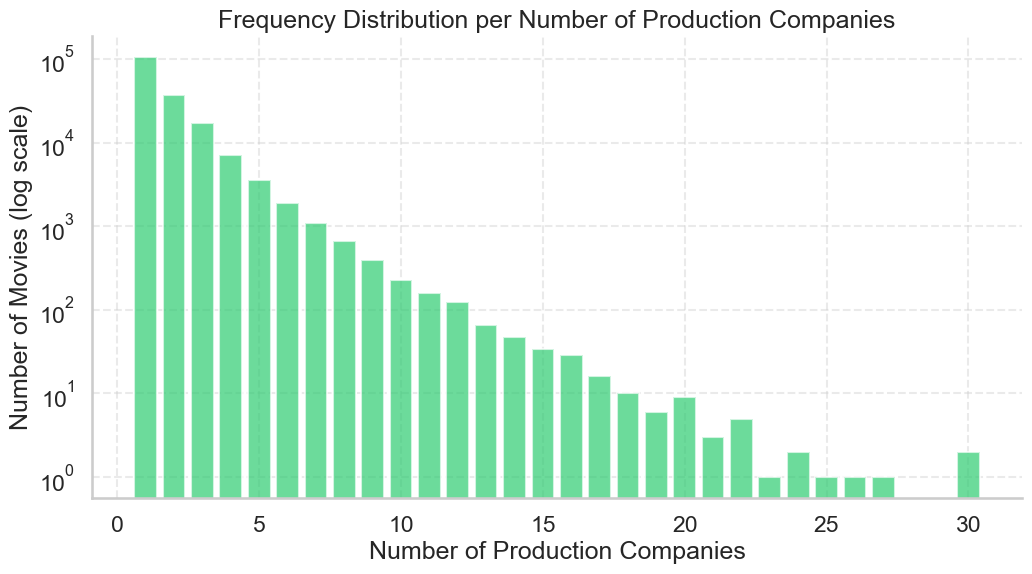

In [87]:
company_counts = company_counts[company_counts.index > 0]
plt.figure(figsize=(12, 6))
plt.bar(company_counts.index, company_counts.values, color='#2ecc71', alpha=0.7, edgecolor='white')

plt.yscale('log')
style_plot('Frequency Distribution per Number of Production Companies', 'Number of Production Companies', 'Number of Movies (log scale)', False)

 Interestingly, there are a high number of movies with more than one production company. Production companies have the resources (creative or financial) to make the movies possible. It would be interesting to see how the number of production companies per movie has evolved over time. 

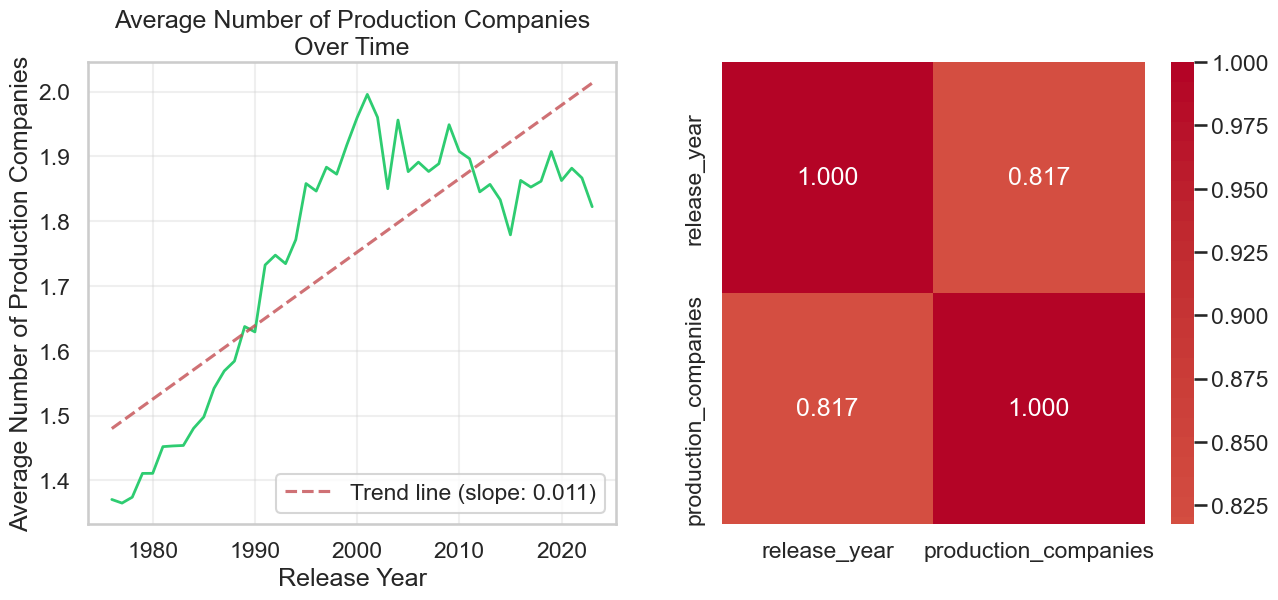

In [29]:
# Get mean number of production companies per year
yearly_avg_companies = (df[df['production_companies'].str.len() > 0].groupby('release_year')
                       .agg({'production_companies': lambda x: x.str.len().mean()})
                       .reset_index())

# Create 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot mean number of production companies per year
ax1.plot(yearly_avg_companies['release_year'], 
             yearly_avg_companies['production_companies'],
             linewidth=2,
             color='#2ecc71')

# Add linear fit to the plot 
z = np.polyfit(yearly_avg_companies['release_year'], 
               yearly_avg_companies['production_companies'], 1)
p = np.poly1d(z)
ax1.plot(yearly_avg_companies['release_year'], 
         p(yearly_avg_companies['release_year']), 
         "r--", 
         alpha=0.8,
             label=f'Trend line (slope: {z[0]:.3f})')

ax1.set_title('Average Number of Production Companies\nOver Time')
ax1.set_xlabel('Release Year')
ax1.set_ylabel('Average Number of Production Companies')
ax1.grid(True, alpha=0.3)
ax1.legend()
    
correlation = yearly_avg_companies['release_year'].corr(yearly_avg_companies['production_companies'])
covariance = yearly_avg_companies['release_year'].cov(yearly_avg_companies['production_companies'])

# Plot correlation between number of production companies and release year
sns.heatmap(yearly_avg_companies.corr(), 
                annot=True, 
                cmap='coolwarm', 
                center=0,
                fmt='.3f',
                ax=ax2)
plt.show()


From this initial analysis, there is a strong correlation between the number of production companies per movie and the release year. 

In [30]:
print(df['production_companies'].explode().value_counts().describe())

count    86944.000000
mean         3.613809
std         18.178683
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       1439.000000
Name: count, dtype: float64


We then plot the number of movies produced per production company, considering production companies in decreasing order in terms of how many movies they produce. We use a log-log scale and notice a power law trend.

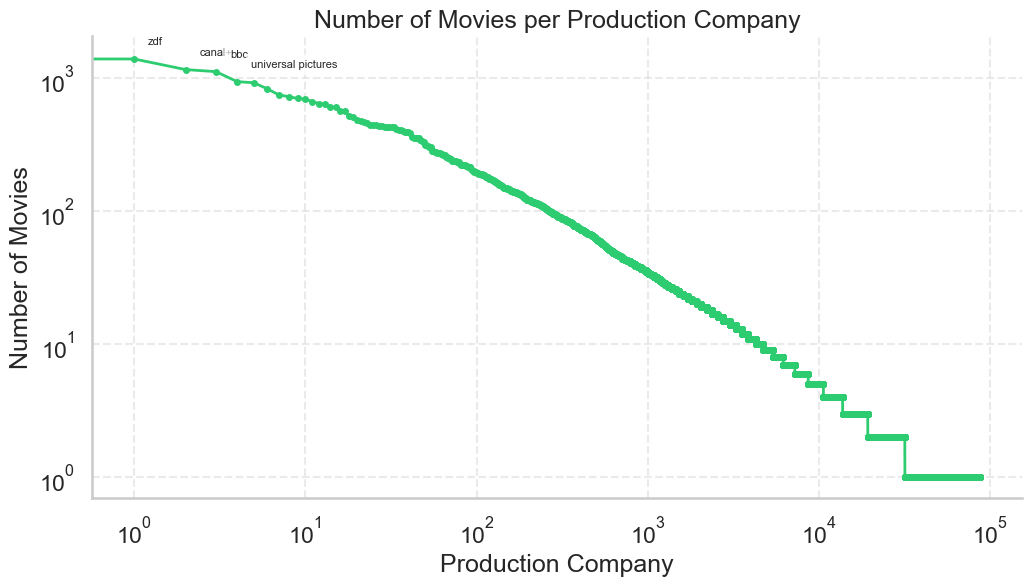

In [31]:
plot_movie_freq_per_production_company(df)

This plot here shows us the number of movies each production company has produced. Notice that there are huge differences in the number of movies produced by each production company and clear 'dominance' of a few production companies. Let's look at those dominant production compnaies by looking atthe top 100 production companies. 

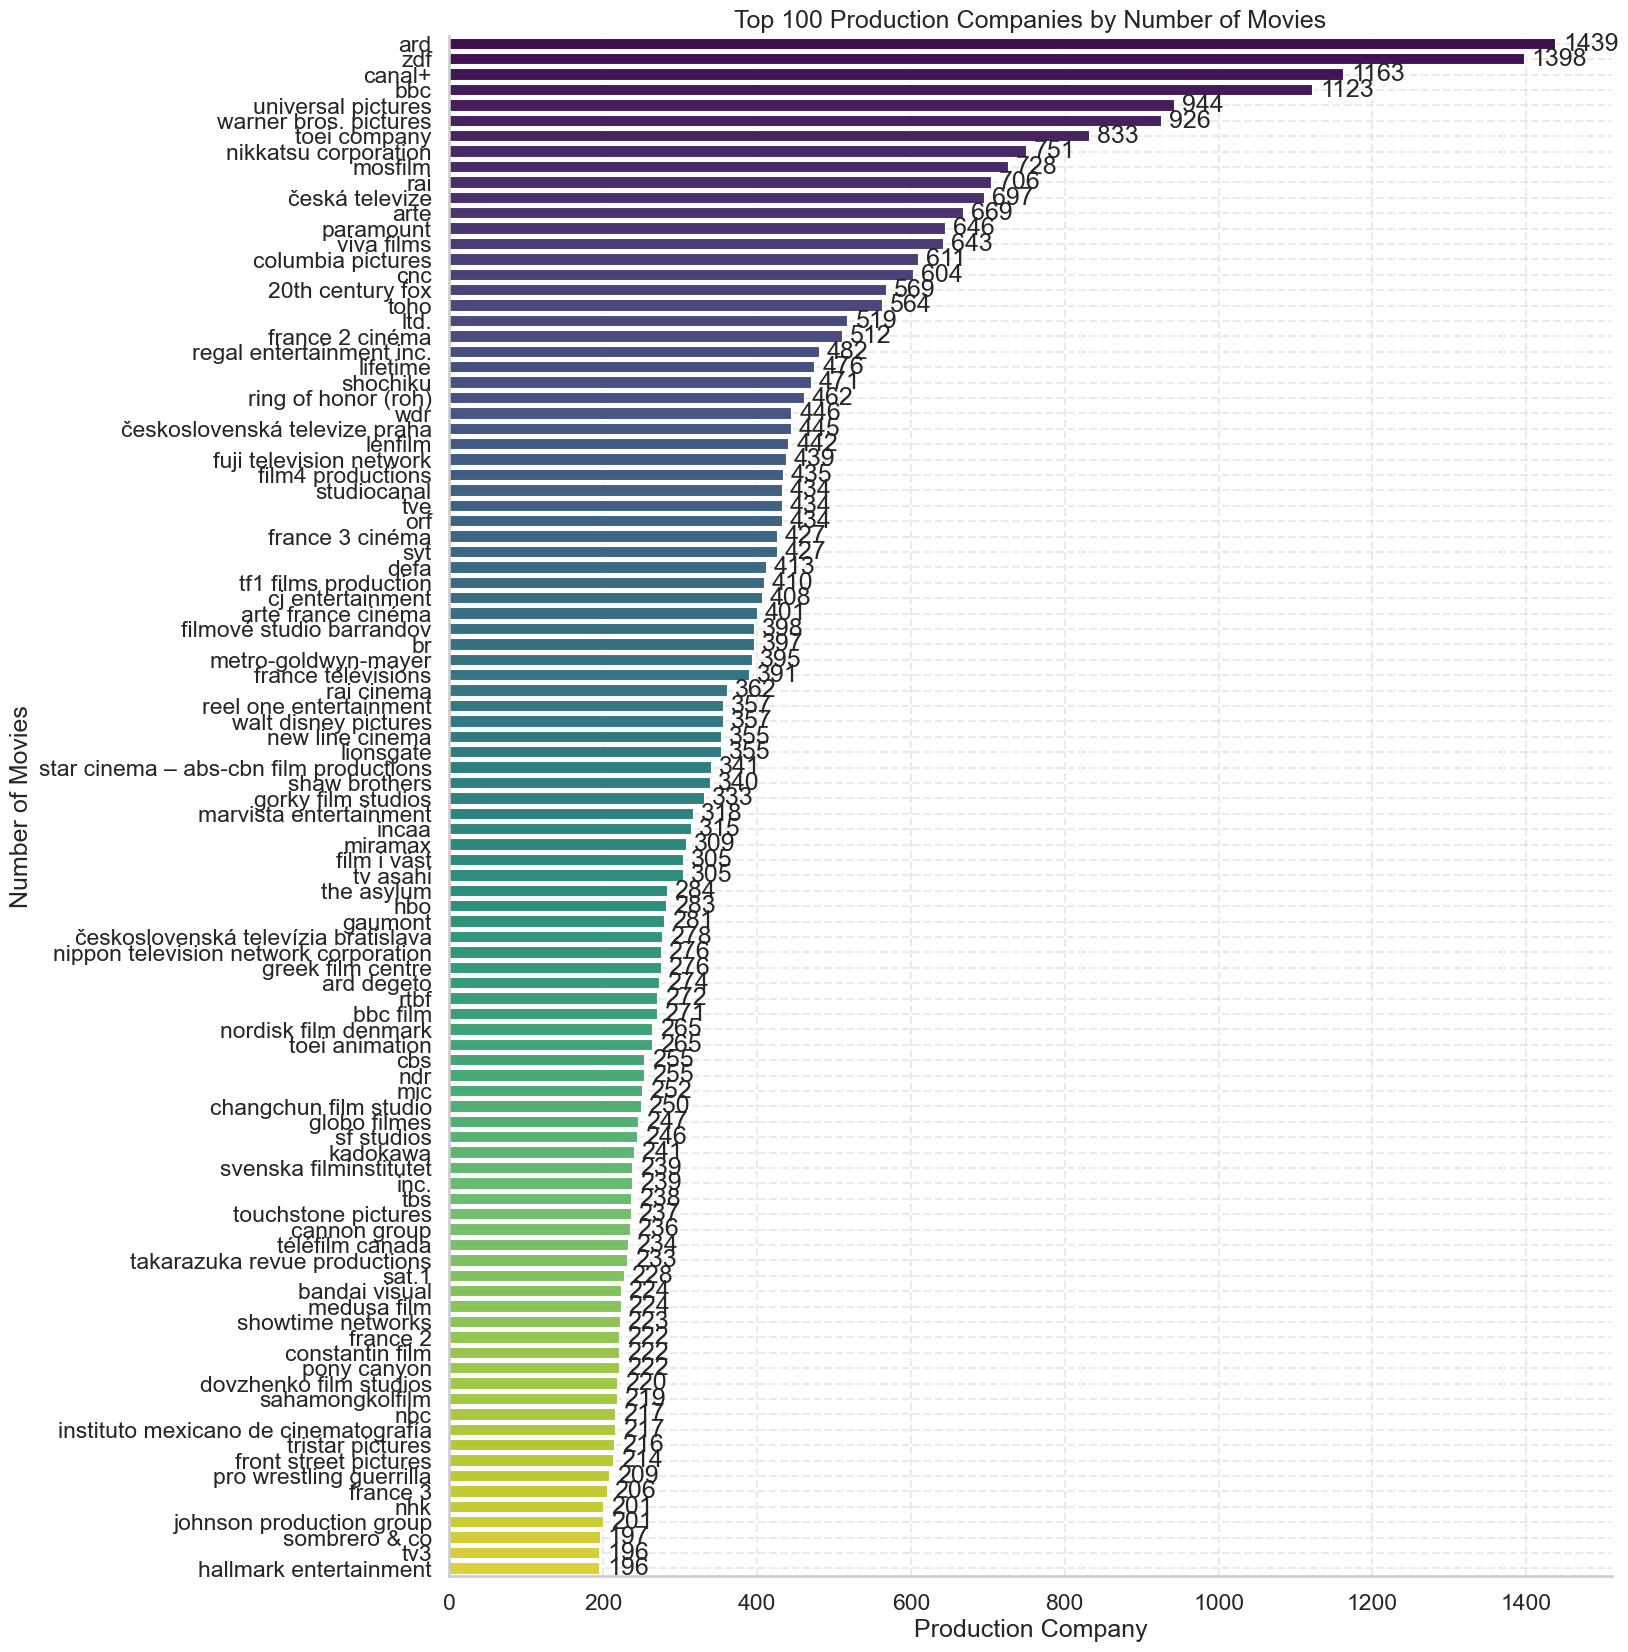

In [32]:
# Get number of movies produced by top 100 production companies
top_100_companies = df['production_companies'].explode().value_counts().head(100)

# plot the values 
plt.figure(figsize=(15, 20))

ax = sns.barplot(
    y=top_100_companies.index,
    x=top_100_companies.values,
    palette='viridis',
    hue=top_100_companies.index,
    legend=False
)
for i in ax.containers:
    ax.bar_label(i, padding=5)
ax.grid(axis='x', linestyle='--', alpha=0.7)
style_plot('Top 100 Production Companies by Number of Movies', 'Production Company', 'Number of Movies', False)

There are some production companies that have a very high number of movies for P3 it would be interesting to find out why they are so successful 

# Genre overview
For each DVD era, we obtain the top-10 movie genres based on the proportion of movies.


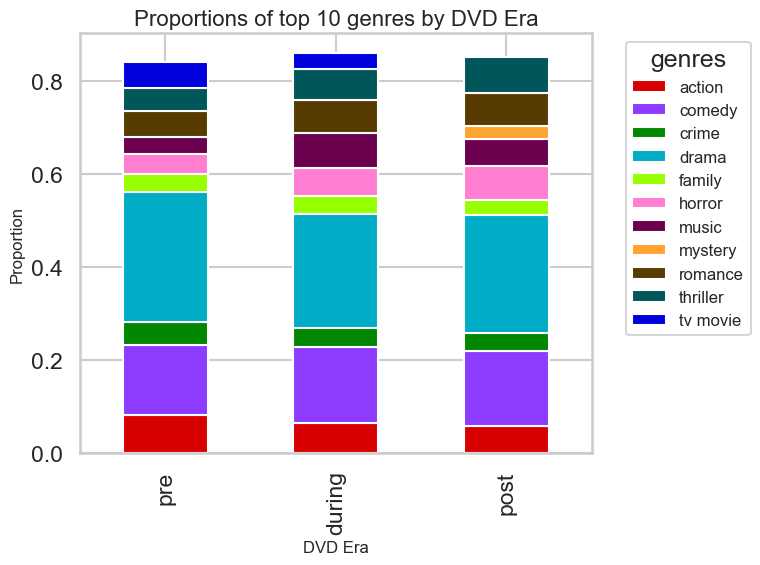

In [35]:
top_10_genre =top_proportions_per_era(df, 'genres', 10, True)
plot_top_proportions_per_era(top_10_genre, 'genres', 10)

# Theme extraction

For the major genres, we use LDA to extract the main topics in movies of the genre, with the goal of checking whether the main topics change overtime. Here is an example of topic extraction for the Drama movie genre, which appears to be the most common genre in the plot above. 

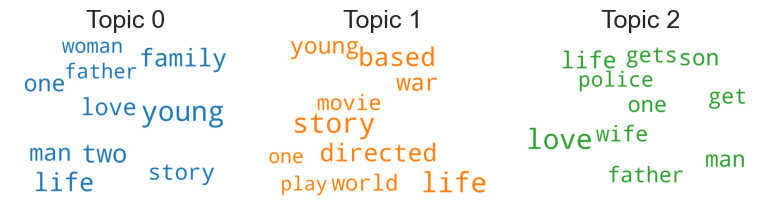

In [37]:
# Pre-process movie plots, lowercase, removing stopwords & special characters
df['clean_overview'] = df.overview.apply(clean_text)

# Extract plots for Drama genre and pre-DVD era
text_data = get_movie_plots(df, 'drama', 'pre')
# Extract 3 main topics 
model = LDAModel(text_data, 3)
model.train()
model.plot_topics()

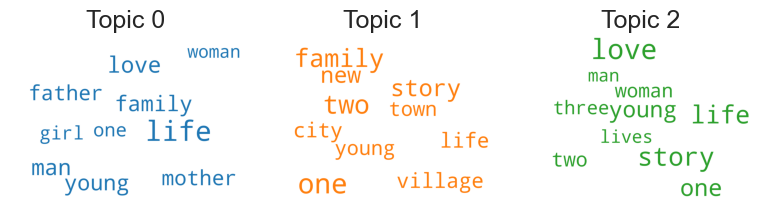

In [38]:
text_data = get_movie_plots(df, 'drama', 'during')
model = LDAModel(text_data, 3)
model.train()
model.plot_topics()

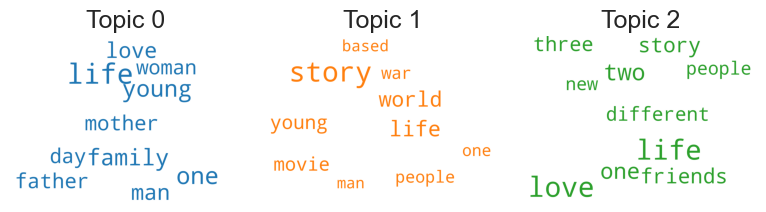

In [39]:
text_data = get_movie_plots(df, 'drama', 'post')
model = LDAModel(text_data, 3)
model.train()
model.plot_topics()

# Special types of movies
## Remakes 


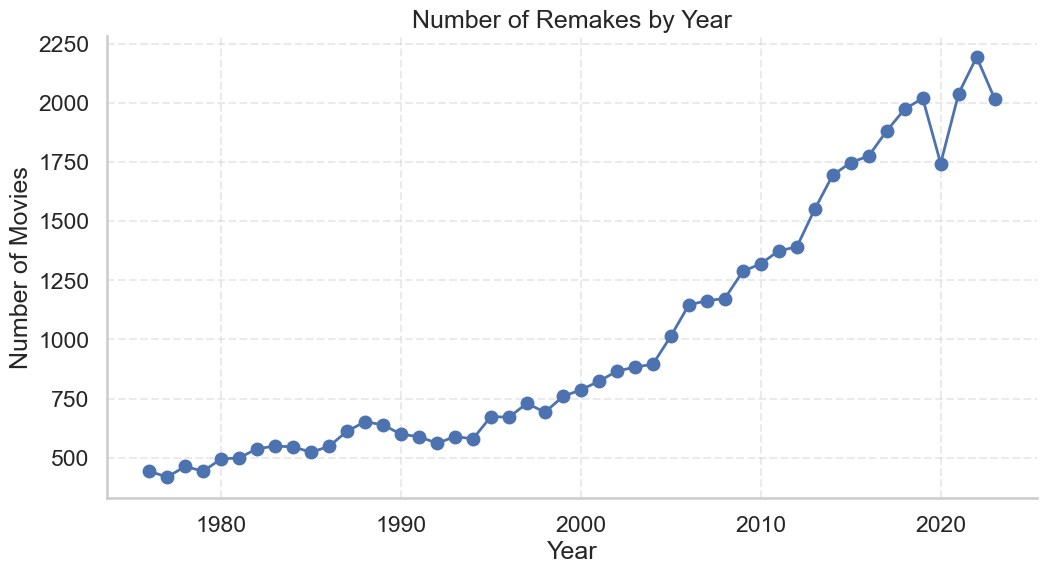

In [40]:
remakes = (df.groupby('title')
           .agg({'release_year': ['count']}) # count for each year the number of times the same title appears
           .reset_index())

remakes = remakes[remakes[('release_year', 'count')] > 1] # Ensure we only keep titles that appear multiple times

yearly_remakes = (df[df['title'].isin(remakes['title'])]
                 .groupby('release_year')
                 .size())

plt.figure(figsize=(12, 6))
plt.plot(yearly_remakes.index, yearly_remakes.values, 
         marker='o', 
         linewidth=2)
style_plot('Number of Remakes by Year', 'Year', 'Number of Movies', False)

In [41]:
remakes.head()

,title,release_year
,,count
66,#,2
266,'twas the night before christmas,2
350,+1,2
369,.,3
506,1,4


In [42]:
print(remakes.info())

<class 'pandas.core.frame.DataFrame'>
Index: 16837 entries, 66 to 329564
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   (title, )              16837 non-null  object
 1   (release_year, count)  16837 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 394.6+ KB
None
